tt1 0.6
n_obs 10 batch_size 1 t1 [[0.6]] x [[ 0.45 -0.09  1.88  0.88  0.13 -2.04 -2.21 -3.01 -0.34 -0.33]]
tt1 0.6
n_obs 10 batch_size 1 t1 [[0.6]] x [[-0.64  1.14 -0.1  -0.86 -1.19 -0.83 -1.69 -0.67 -1.57 -0.54]]
tt1 [ 0.72  0.13 -0.94  0.61 -0.68 -0.46  0.04 -0.79  1.03 -0.15  1.62  0.19
  1.36 -0.03 -0.02 -0.08  0.92  1.86  1.17  0.45 -0.81 -0.97 -0.01]
n_obs 10 batch_size 23 t1 [[ 0.72]
 [ 0.13]
 [-0.94]
 [ 0.61]
 [-0.68]
 [-0.46]
 [ 0.04]
 [-0.79]
 [ 1.03]
 [-0.15]
 [ 1.62]
 [ 0.19]
 [ 1.36]
 [-0.03]
 [-0.02]
 [-0.08]
 [ 0.92]
 [ 1.86]
 [ 1.17]
 [ 0.45]
 [-0.81]
 [-0.97]
 [-0.01]] x [[ 7.85e-02 -9.35e-01 -1.84e+00 -3.03e+00 -1.21e+00 -4.35e-01 -6.87e-01
  -1.28e+00 -1.69e+00  1.99e-01]
 [ 1.07e+00  2.08e-01 -1.88e+00  4.90e-01  1.27e+00 -1.70e+00  1.89e-01
  -1.71e-01 -1.92e-01  1.83e+00]
 [ 1.28e+00 -1.58e+00 -2.09e-01  9.58e-01  9.74e-01 -1.05e+00  2.12e+00
  -1.18e+00  1.78e+00 -1.44e-01]
 [ 2.47e+00  2.44e+00 -4.90e-01 -7.34e-01 -1.36e+00  1.29e+00  1.50e+00
   2.37e+00  3.71e

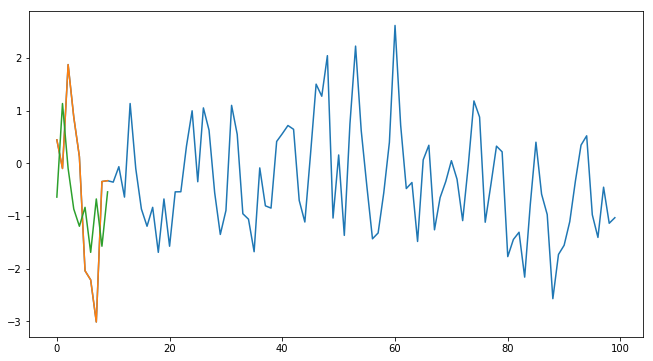

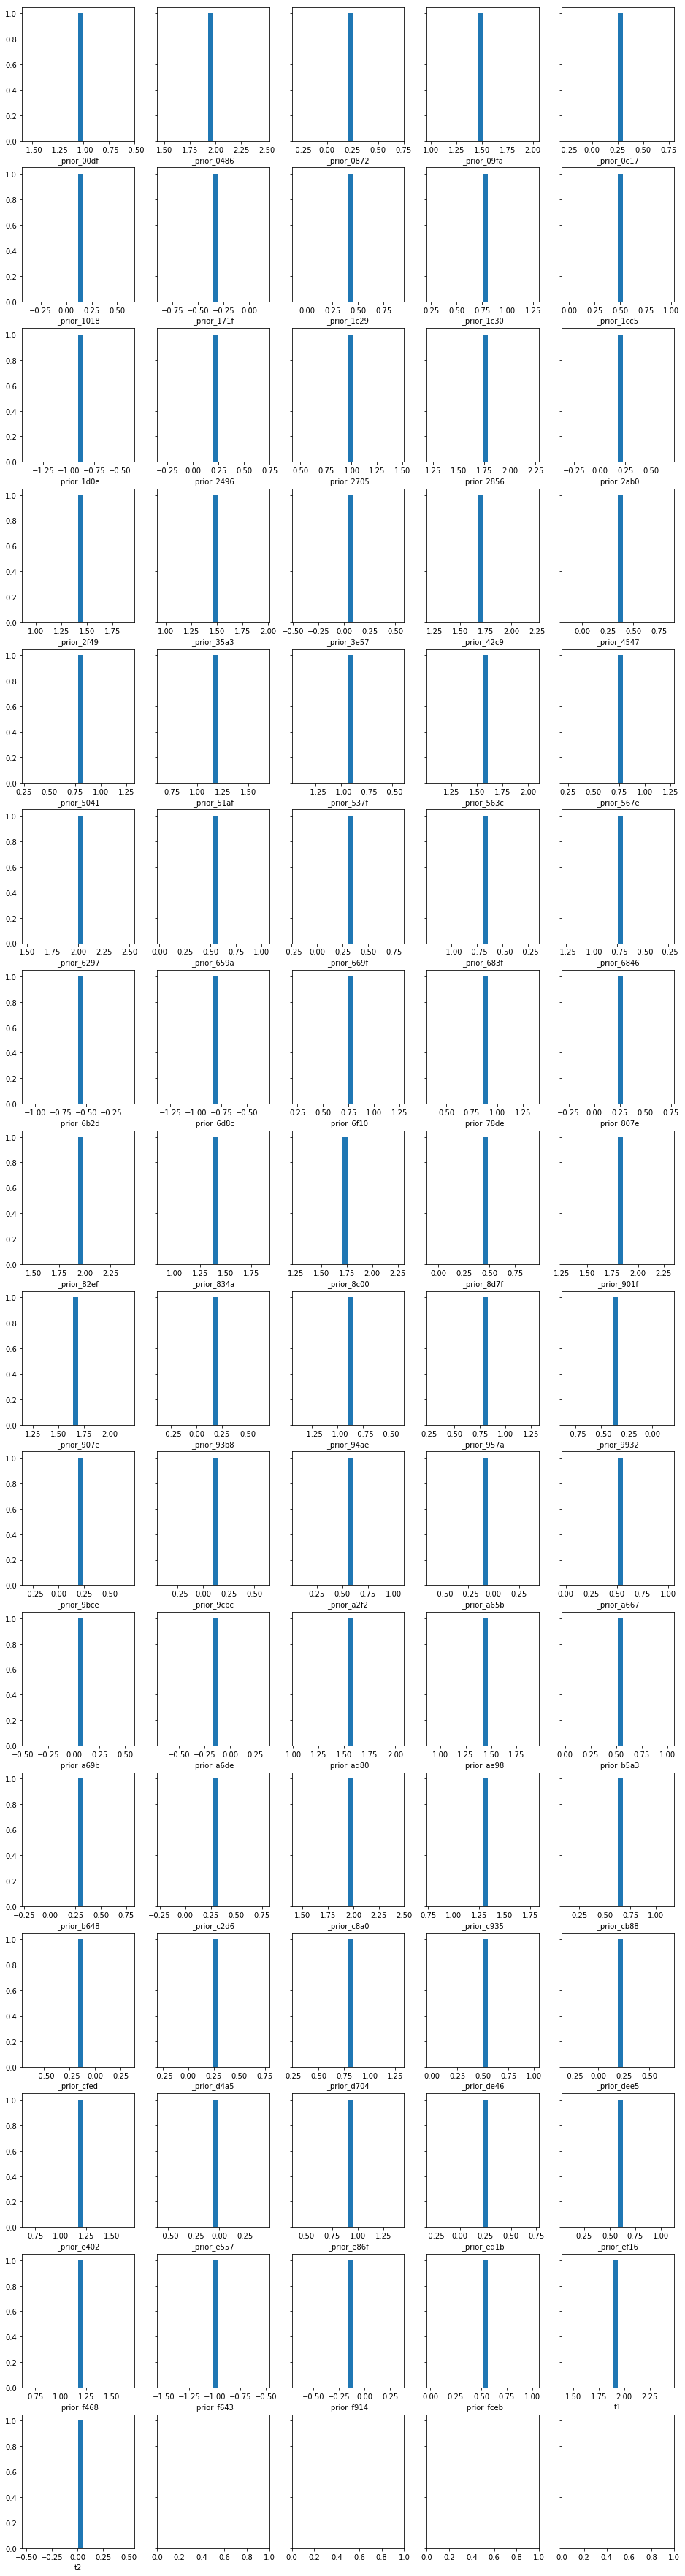

In [40]:
import time

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)  # sometimes this is required to enable logging inside Jupyter
import elfi
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

%matplotlib inline
%precision 2

# Set an arbitrary seed and a global random state to keep the randomly generated quantities the same between runs
seed = 20170530
np.random.seed(seed)

def MA2(t1, t2, n_obs=10, batch_size=1, random_state=None):
    print('tt1', t1)
    # Make inputs 2d arrays for numpy broadcasting with w
    t1 = np.asanyarray(t1).reshape((-1, 1))
    t2 = np.asanyarray(t2).reshape((-1, 1))
    random_state = random_state or np.random

    w = random_state.randn(batch_size, n_obs+2)  # i.i.d. sequence ~ N(0,1)

    x = w[:, 2:] + t1*w[:, 1:-1] + t2*w[:, :-2]
    print('n_obs', n_obs, 'batch_size', batch_size, 't1', t1, 'x', x)
    
    return x

# print(y_obs)
# Plot the observed sequence
plt.figure(figsize=(11, 6));
plt.plot(y_obs.ravel());

# To illustrate the stochasticity, let's plot a couple of more observations with the same true parameters:
plt.plot(MA2(t1_true, t2_true).ravel());
plt.plot(MA2(t1_true, t2_true).ravel());

# a node is defined by giving a distribution from scipy.stats together with any arguments (here 0 and 2)
t1 = elfi.Prior(scipy.stats.uniform, 0, 2)

# ELFI also supports giving the scipy.stats distributions as strings
t2 = elfi.Prior('uniform', 0, 2)

Y = elfi.Simulator(MA2, t1, t2, observed=y_obs)

def autocov(x, lag=1):
#     print(x)
#     print("=================")
    C = np.mean(x[:,lag:] * x[:,:-lag], axis=1)
    return C

S1 = elfi.Summary(autocov, Y)
S2 = elfi.Summary(autocov, Y, 2)  # the optional keyword lag is given the value 2

# Finish the model with the final node that calculates the squared distance (S1_sim-S1_obs)**2 + (S2_sim-S2_obs)**2
d = elfi.Distance('euclidean', S1, S2)

# define prior for t1 as in Marin et al., 2012 with t1 in range [-b, b]
class CustomPrior_t1(elfi.Distribution):
    def rvs(b, size=1, random_state=None):
        u = scipy.stats.uniform.rvs(loc=0, scale=1, size=size, random_state=random_state)
        t1 = np.where(u<0.5, np.sqrt(2.*u)*b-b, -np.sqrt(2.*(1.-u))*b+b)
        return t1

# define prior for t2 conditionally on t1 as in Marin et al., 2012, in range [-a, a]
class CustomPrior_t2(elfi.Distribution):
    def rvs(t1, a, size=1, random_state=None):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        t2 = scipy.stats.uniform.rvs(loc=locs, scale=scales, size=size, random_state=random_state)
        return t2

t1.become(elfi.Prior(CustomPrior_t1, 2))
t2.become(elfi.Prior(CustomPrior_t2, t1, 1))

rej = elfi.Rejection(d, batch_size=23, seed=seed)

N = 1

# You can give the sample method a `vis` keyword to see an animation how the prior transforms towards the
# posterior with a decreasing threshold.
result = rej.sample(N, quantile=0.01)
result.summary()
result.plot_marginals();